#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:120%;text-align:center;border-radius:10px 10px;">CRYPTOCURRENCY FORECASTING</p>

I create a forecasting model for fifteen-minute price movements of popular cryptocurrency assets. 
* I examine statistical properties of the time series, specifically autocorrelation and stationarity, to inform my modeling. 
* I engineer a number of features, including popular technical financial indicators, as well as rolling averages and first and second derivatives of various features.
* I perform feature-selection using Pearson correlations and feature importances. 
* I fit to an XGBoost model, and compare performance with persistence model and linear regression baselines.

My forecasting model produces a weighted correlation value of 0.049. By typical standards for forecasting models, this result is pitifully low. But this is not a typical forecasting problem for a number of reasons. 
* The efficient market hypothesis states that any strategy leading to reliable profits (like a more accurate forecasting model) is impossible.
* Cryptocurrences are wildly volatile. 
* The prediction target is the fifteen-minute log return, subtracted by a term that accounts for general market behavior. Overall market trends are therefore useless for forecasting. 

The dataset I use is provided publicly by the finance company G-Research, and runs from 2018 to 2021. 

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Importing Data and Libraries</p>

In [1]:
# standard libraries
import sklearn
import numpy as np
import pandas as pd

# time series statistics
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import scipy 

# machine learning modelling 
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# evaluating models
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# plots 
from matplotlib import pyplot as plt 
import seaborn as sns
%matplotlib inline

In [6]:
# File paths
train_file = "train.csv"
asset_file = "asset_details.csv"

# Data imports
df = pd.read_csv(train_file) 
asset_details = pd.read_csv(asset_file)

# Index the time series dataframe by Asset_ID, timestamp
df = df.set_index(keys = ["Asset_ID", "timestamp"]).sort_index()

# Index the asset_details dataframe by Asset_ID
asset_details = asset_details.set_index(keys = ["Asset_ID"]).sort_index()

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Data Overview</p>

The dataframe consists of 14 distinct timeseries, one for each cryptocurrency asset. See the table below for a snippet of Binance Coin's timeseries data. Here is how each column is defined
* Asset_ID: the ID number for each asset. To get the asset name, see dataframe 'asset_details'. 
* timestamp: this is a Unix timestamp, measuring the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC. These timestamps come in 60 second intervals, indicating that data is provided for minute-long time periods. 

In what follows, when I refer to the 'time interval' defined by a timestamp, I mean the minute-long time interval *ending* at the time defined by the timestamp. Here are the features we have access to:
* Count: Total number of trades in the time interval.
* Open and Close: Opening price of the time interval, and Closing price of the time interval (all in USD).
* High and Low: Highest price of the time interval, and Lowest price of the time interval (all in USD). 
* Volume: Quantity of assets bought or sold (in USD). 
* VWAP: Stands for Volume-Weighted Asset Price. This is the average price of the asset over the time interval, weighted by volume. 

The column 'Target' is the feature to be predicted. It measures the overall behavior of the asset price, in the time period from 1 to 15 minutes after the timestamp. Specifically, it is the asset log-return over this time period, subtracted by an expression that measures the overall behavior of the market. Thus, it can be referred to as the 'residual log returns'. It is designed so that it qualitatively describes the behavior of the specific asset over time, relative to market behavior. 




In what follows, I provide the formal definition for 'Target', though the qualitative definition above should suffice for understanding. Feel free to skip if uninterested. 

Target is defined as follows:
$$\text{Target}_a(t) = R_a(t) - \beta_a(t) M(t)$$ 

In this expression, the subscript 'a' specifies the cryptocurrency asset. $R_a(t)$ is defined as log returns over 15 minutes,
$$R_a(t) = \log(P_a(t + 16) / P_a(t + 1)).$$

Furthermore, M(t) measures the overall market behavior, as the weighted average of all log returns:
$$ M(t) = \frac{\sum_a w_a R_a(t)}{\sum_a w_a},$$

and $\beta_a$ measures the correlation between the market $M(t)$ and the log-returns $R_a(t)$: 
$$ \beta_a(t) = \frac{< M * R_a >(t)}{< M^2 >(t)}.$$

The brackets perform a rolling average over 3750-minute windows, though G-Research did not explain (1) how it handles missing values for the purposes of computing 'Target', or (2) whether this window is centered around time 't' or biased left or right. $\beta_a(t)$ functionally serves to rescale $M(t)$ such that $\beta_a(t) M(t)$ represents a sort of 'expected' log-return $R_a(t)$ were the asset $a$ to follow market behavior. This justifies referring to the target as a residual log return. 

In [7]:
df.head()

Count    Open    High     Low   Close   Volume      VWAP  \
Asset_ID timestamp                                                              
0        1514764860    5.0  8.5300  8.5300  8.5300  8.5300    78.38  8.530000   
         1514764920    7.0  8.5300  8.5300  8.5145  8.5145    71.39  8.520215   
         1514764980   45.0  8.5065  8.5299  8.4848  8.4848  1546.82  8.501394   
         1514765040   14.0  8.5009  8.5066  8.4744  8.5009   125.80  8.479810   
         1514765100    5.0  8.5007  8.5007  8.4560  8.4560   125.01  8.458435   

                       Target  
Asset_ID timestamp             
0        1514764860 -0.014399  
         1514764920 -0.015875  
         1514764980 -0.015410  
         1514765040 -0.012524  
         1514765100 -0.005940

The 14-row table below maps each asset ID (Asset_ID) to an specific asset (Asset_Name). Each asset also has a 'Weight', defining the importance of that asset relative to others. The company G-Research defined these weight values, and I do not have access to information on how these weights were chosen. 

In [8]:
asset_details

,Weight,Asset_Name
Asset_ID,,
0,4.304065,Binance Coin
1,6.779922,Bitcoin
2,2.397895,Bitcoin Cash
3,4.406719,Cardano
4,3.555348,Dogecoin
5,1.386294,EOS.IO
6,5.894403,Ethereum
7,2.079442,Ethereum Classic
8,1.098612,IOTA


According to the table below, all features in the time-series dataframe are numerical. There are a total of 24 million rows. The only columns that have null values, VWAP and Target, have under 400 missing values each. We will decide how to handle these missing values later. 

In [89]:
# Small number of missing values in "VWAP" and "Target". Should investigate why they are missing. 
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   timestamp  24236806 non-null  int64  
 1   Asset_ID   24236806 non-null  int64  
 2   Count      24236806 non-null  float64
 3   Open       24236806 non-null  float64
 4   High       24236806 non-null  float64
 5   Low        24236806 non-null  float64
 6   Close      24236806 non-null  float64
 7   Volume     24236806 non-null  float64
 8   VWAP       24236797 non-null  float64
 9   Target     23486468 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


Although there are few null values in our dataframe, we actually have many more missing values than it seems. For each cryptocurrency asset, we would expect a row of data for every minute, from the earliest timestamp to the latest timestamp available for that asset. But sometimes data for a minute is missing. See below for the percentage of missing rows for each asset. 

In the most extreme case, asset 10 ('Maker' cryptocurrency), we have 62% of our expected timestamps missing! This will certainly become an issue worth considering during model training and forecasting.

The company G-Research did not provide an explanation of the missing data along with their datasets, so I do not know whether these timestamps are missing because of incomplete data collection or something else. 

In [25]:
for asset_id in range(14):
    num_expected = (df.loc[asset_id].iloc[-1].name - df.loc[asset_id].iloc[0].name) / 60  + 1
    num_true = df.loc[asset_id].shape[0]
    print("For asset_id = {}, missing {:.2f}% timestamps".format(asset_id, 100 * (1 - num_true / num_expected)))

For asset_id = 0, missing 0.73% timestamps
For asset_id = 1, missing 0.03% timestamps
For asset_id = 2, missing 0.17% timestamps
For asset_id = 3, missing 0.66% timestamps
For asset_id = 4, missing 9.97% timestamps
For asset_id = 5, missing 0.09% timestamps
For asset_id = 6, missing 0.04% timestamps
For asset_id = 7, missing 0.30% timestamps
For asset_id = 8, missing 10.16% timestamps
For asset_id = 9, missing 0.05% timestamps
For asset_id = 10, missing 62.12% timestamps
For asset_id = 11, missing 13.07% timestamps
For asset_id = 12, missing 5.85% timestamps
For asset_id = 13, missing 1.54% timestamps


Furthermore, the asset time series do not all start at the same time! Six assets, listed below, have data that starts later than the other assets.

In [40]:
min_time = min(df.loc[asset_id].iloc[0].name for asset_id in range(14))
max_time = max(df.loc[asset_id].iloc[-1].name for asset_id in range(14))
print("The earliest timestamp of all assets is {}, and the latest timestamp is {}".format(min_time, max_time))
print('But some assets start data collection at a different timestamp:')
for asset_id in range(14):
    min_asset_time = df.loc[asset_id].iloc[0].name
    max_asset_time = df.loc[asset_id].iloc[-1].name
    if min_asset_time != min_time:
        print("The asset_ID {}'s earliest timestamp is {}".format(asset_id, min_asset_time))
    if max_asset_time != max_time: 
        print("The asset_ID {}'s latest timestamp is {}".format(asset_id, max_asset_time))

The earliest timestamp of all assets is 1514764860, and the latest timestamp is 1632182400
But some assets start data collection at a different timestamp:
The asset_ID 3's earliest timestamp is 1523956260
The asset_ID 4's earliest timestamp is 1555079640
The asset_ID 8's earliest timestamp is 1525853220
The asset_ID 10's earliest timestamp is 1525965660
The asset_ID 12's earliest timestamp is 1518825180
The asset_ID 13's earliest timestamp is 1517953020


The bar plot below shows the asset weights for each cryptocurrency, reflecting the importance assigned by G-Research to each asset. 

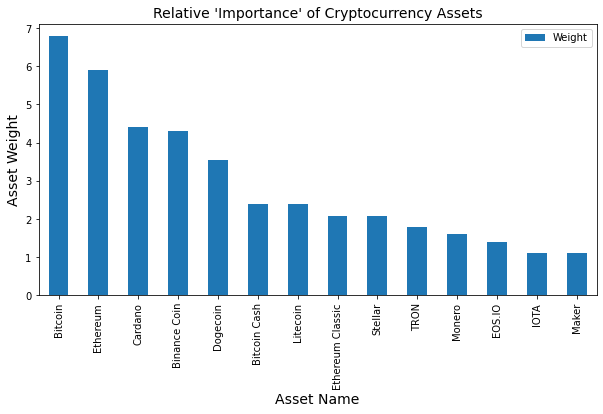

In [43]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
asset_details.sort_values(by = "Weight", ascending = False).plot.bar(x = "Asset_Name", y = "Weight", ax = ax)
ax.set_xlabel("Asset Name", fontsize = 14)
ax.set_ylabel("Asset Weight", fontsize = 14)
plt.title("Relative 'Importance' of Cryptocurrency Assets", fontsize = 14)
plt.show()

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Statistical Analysis of Time Series </p>

Below are plots of the target, for three example assets, over the course of 6 hours. Looking at these plots, we see that the curves seem to be centered around 0 with a fairly steady variance. Given these properties, it is worth checking -using the Dickey-Fuller test- whether the time series is in fact stationary. A stationary property to our time series may make forecasting somewhat easier. 

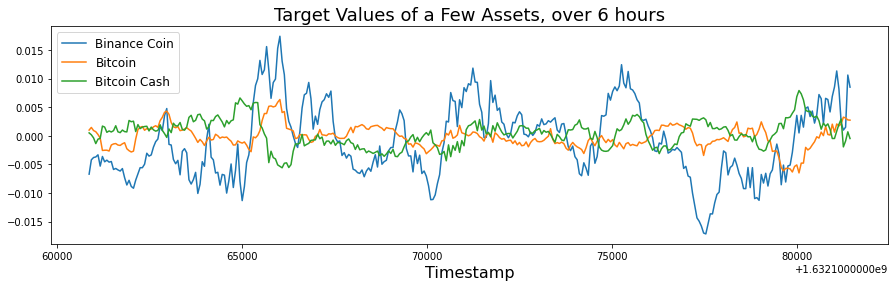

In [59]:
fig, ax = plt.subplots(1,1,figsize = (15,4))
for asset_id in range(3):
    x = df.loc[asset_id].iloc[-6 * 60:].index 
    y = df.loc[asset_id].iloc[-6 * 60:].Target
    plt.plot(x, y, label = asset_details.loc[asset_id, "Asset_Name"])
plt.title("Target Values of a Few Assets, over 6 hours", fontsize = 18)
plt.legend(fontsize = 12)
plt.xlabel("Timestamp", fontsize = 16)
plt.show()

I apply the Dickey Fuller test to check for stationarity of our time series, 'Target', for each asset, in the hidden code block below. Each time series has quite a few data points, so I restrict to only testing 100k data points each (about one tenth of each time series) for the sake of saving runtime.

The p-values that result from the Dickey Fuller test are miniscule. They are all far smaller than necessary to satisfy the traditional 5% significance threshold, so the time series are stationary with very high certainty! This means, among other properties, that there are no significant trends in the mean or variance over time. For the purposes of forecasting, this means it will likely not be helpful to perform differencing or introduce a 'timestamp' feature for prediction purposes. 

In [63]:
# The p-values are so small that Python automatically rounds them down to zero! 
pvalues = [adfuller(df.loc[asset_id, "Target"].iloc[-100000:].dropna())[1] for asset_id in range(14)]
print("The p-values from the Dickey-Fuller test are: ", pvalues)

The p-values from the Dickey-Fuller test are:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


The weighted average of all assets, at any time, should vanish, based on the formal definition given by G-Research. This is proven in the expression below. But according to the plot below, the weighted average fails to vanish. It even stays at the same order of magnitude as the targets for each asset, indicating that its failure to vanish is not about accumulated numerical error in the components used to calculate it. 

$$\frac{\sum_a w_a \text{Target}_a(t)}{\sum_a w_a} = \frac{\sum_a w_a R_a(t)}{\sum_a w_a} - \frac{< M * \sum_a R_a >(t)}{< M^2 >(t)} * M(t) = M(t) - \frac{<M^2>(t)}{<M^2>(t)}\, M(t) = 0
$$

There must be, I think, a subtlety in the code of how G-Research computes 'Target', which is not reflected in their definition and which causes this contradiction. I cannot look into this further because I don't have their code for computing the Target. 

Unfortunately, then, the Target lacks some nice properties that it should have had, and that might have aided forecasting. 

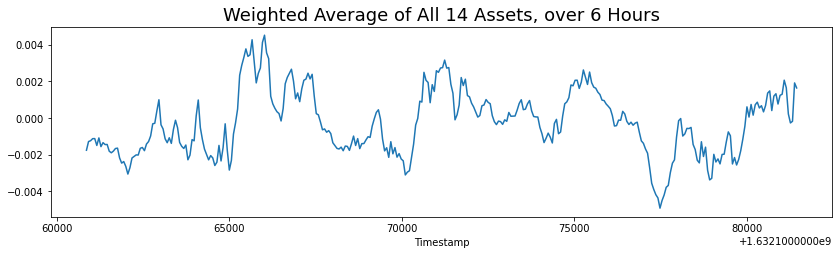

In [71]:
fig, ax = plt.subplots(1,1, figsize = (14,3.5))
plt.plot(
    sum(
        df.loc[asset_id].iloc[-6 * 60:].Target \
        * asset_details.loc[asset_id, "Weight"] / asset_details.Weight.sum() \
    for asset_id in range(14)))
plt.title("Weighted Average of All 14 Assets, over 6 Hours", fontsize = 18)
plt.xlabel("Timestamp")
plt.show()

Continuing our time series analysis, see the plot below for the autocorrelations for an example asset (Binance Coin). For time differences of 0 to 14 minutes, the autocorrelation is significant and positive. 

It would seem that the previous Target values 1-14 minutes, $\text{Target}_a(t - 14), \cdots, \text{Target}_a(t - 1)$, should be highly beneficial for forecasting of the next target value, $\text{Target}_a(t)$. However, this observation is unfortunately false. Recall that the Target is defined by asset price values 15 minutes into the future. We therefore *cannot* know, at time t, any Target value at times $t - 14$ onwards. 

We can only know target values at least 15 minutes into the past. We see that autocorrelations are, within 5% significance, vanishing at this degree of lag. This result is unfortunate yet entirely to-be-expected. After all, the efficient market hypothesis tells us that we should not be able predict the future asset values. A significant correlation would have defied this principle. 

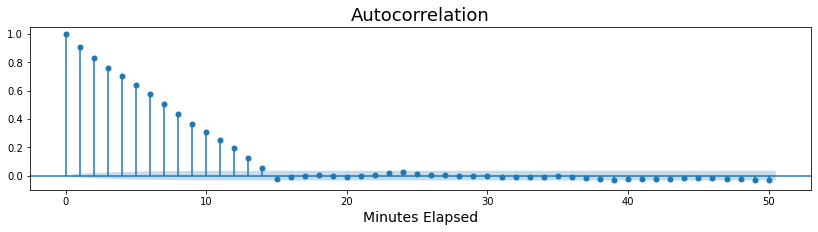

In [78]:
# Autocorrelation
fig, ax = plt.subplots(1,1,figsize = (14,3))
plot_acf(df.loc[0].Target.dropna().iloc[-30000:], lags = 50, ax = ax)
plt.ylim(-0.1, 1.05)
plt.xlabel("Minutes Elapsed", fontsize = 14)
plt.title("Autocorrelation", fontsize = 18)
plt.show()

In [ ]:
# These are Granger-Causality Tests, used to check whether one time series can be used for forecast another. 
# But in retrospect these tests didn't make much sense to run. Even autocorrelations within the SAME time series show no predictive 
# value (through direct correlation). It is unfeasible that different asset time series would have a strong Granger-causality, when the same-asset time series does not.
# It is not worth running. If it were, I should lag one time series by fifteen minutes to ensure that I'm respecting what I could possibly know while forecasting
# the other. 

# # Granger Causality Tests 
# n_asset = 2
# maxlag = 3
# test_type = "ssr_chi2test"
# granger_matrix = [[None for _ in range(n_asset)] for _ in range(n_asset)]

# for i in range(n_asset):
#     for j in range(n_asset):
#         # skip diagonals
#         if i == j: continue
        
#         # get time series data for the two assets
#         target1, target2 = df.loc[i, "Target"].dropna(), df.loc[j, "Target"].dropna()
#         target1, target2 = pad_series(target1), pad_series(target2) # fill in missing time points in each time series 
#         merged = pd.merge(target1, target2, how = "inner", left_index = True, right_index = True, suffixes = ("_1", "_2"))
        
#         # granger causality test 

#         test_result = grangercausalitytests(merged, maxlag = maxlag, verbose = 0) # Target_1: response. Target_2: predictor. 
#         p_values = [round(test_result[k + 1][0][test_type][1], 4) for k in range(maxlag)] 
#         min_p_value = np.min(p_values)
        
#         # save in matrix
#         granger_matrix[i][j] = min_p_value
        
# asset_list = list(asset_details.sort_values(by = "Asset_ID").Asset_Name.values)
# pd.DataFrame(granger_matrix, columns = asset_list[:n_asset], index = asset_list[:n_asset])

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Feature Engineering and Feature Selection</p>

At this point, I could immediately create a forecasting model, using the features I have already been given (Count, Open, Close, High, Low, Volume, VWAP). However, we should suspect that feature engineering has the potential to significantly increase our predictive power. After all, financial analysis use a very large variety of technical indicators to understand and forecast the market. I'll engineer and add a few new features to our dataframe, listed below. They are only a very small subset, however, of features that could be useful. Were I to keep working on improving my forecasting model, I think further feature engineering would be the best investment of time. 

* Upper Shadow: Difference between maximum price in time interval, and maximum of Open and Close. Some financial analysis believe that a large Upper Shadow implies a soon-to-be downturn. 
* Lower Shadow: Difference between minimum price in time interval, and minimum of Open and Close. Some financial analysis believe that a large Lower Shadow implies a soon-to-be rise. 
* Target (Shifted): The target itself can be used as a feature, as long as we only use the target values we would know at the time of prediction, i.e. 15 minutes before.
* Log Return (15 minute time period): Log return, defined in the 'Data Overview' section, is a component of the Target.
* Weighted Average of Market Returns over All Assets: This is the market behavior, M(t), defined in the 'Data Overview' section. 
* Rolling Average of Target: The rolling average of the target should be taken over some window of time, and the size of this window is to-be-determined. 
* Rolling Standard Deviation of Target: The rolling standard deviation should describe overall volatility in recent times. The size of this window is to-be-determined.

After engineering these features, I'll perform feature selection, using Pearson correlation coefficients between every feature and the true Target to be predicted. This will help us decide which features to use in the final model. 

In the hidden code block below, I engineer the first 5 features listed earlier. 

In [104]:
# FEATURE CREATION 

# Upper Shadow
df["UpperShadow"] = df.apply(lambda row: row.High - max(row.Close, row.Open), axis = 1)

# Lower Shadow
df["LowerShadow"] = df.apply(lambda row: min(row.Close, row.Open) - row.Low, axis = 1)
                                     
# Shifted-Target
for asset_id in range(14):
    df.loc[asset_id, "TargetShifted"] = df.loc[asset_id].Target.shift(16).values
    
# Log-Returns over last 15 minutes 
for asset_id in range(14):
    log_return_15 = np.log(df.loc[asset_id].Close) - np.log(df.loc[asset_id].Close.shift(15)) 
    df.loc[asset_id, "15_LogReturn"] = log_return_15.values 
    
# Weighted Average of Market Returns, M(t), over 15 minutes, M(t) = sum_a w_a R_a(t)
market_return = pd.Series(sum(asset_details.loc[asset_id, "Normalized_Weight"] \
    * df.loc[asset_id].reindex(range(min_time, max_time + 60, 60), method = "pad").loc[:, "15_LogReturn"].values \
    for asset_id in range(14)), index = range(min_time, max_time + 60, 60))
for asset_id in range(14):
    df.loc[asset_id, "15_MarketReturn"] = market_return.loc[df.loc[asset_id].index].values

We also want to add features for the rolling average and rolling standard deviations of the target, but we need to choose the window size for the rolling statistics. To do this, I compute the rolling statistics for a range of window sizes, and choose the window size that involves the largest-magnitude Pearson correlation with the to-be-predicted Target. This is not a perfect method, because it ignores the possibility of non-linear relationships and information that may be gained from interactions between the rolling statistic and other features. But in the absence of these problems, which is hopefully the case, it is both a good and a simple method. 

Using the produced plots (hidden below), I find that 10-minutes for a rolling average window size and 20-minutes for a rolling standard deviation window size are sufficient to get a nearly maximal correlation-coefficient magnitude. I then make these features, also in the hidden code blocks below. 

In [ ]:
# Identifying which window size to use for a rolling average feature 

# Calculate correlation coefficient between target and rolling average
# Arguments: asset_ID, window_size to be tested, n_timepoints: the number of data points to use in the time series for computing the correlation coefficient.
# A larger n_timepoints is better, but takes more time. 
def correlation_coefficient_rolling(asset_id: int, window_size: int, n_timepoints: int): 
    rolled = df.loc[asset_id].TargetShifted.dropna().rolling(window_size, center = False).mean().iloc[-n_timepoints:]
    true = df.loc[asset_id].Target.dropna().iloc[-n_timepoints:]
    
    rolled_vs_true = pd.concat(
        [rolled, true], axis = 1).dropna()
    
    return np.corrcoef(rolled_vs_true.iloc[:, 0], rolled_vs_true.iloc[:, 1])[0,1]


# Getting the numpy array correlations to carry the correlation coefficient for many window sizes 
window_sizes = range(1,100,5) # not much else going on beyond 100 
n_timepoints = 30000

correlations = np.array([0.0] * len(window_sizes))
for asset_id in range(14):
    weight = asset_details.loc[asset_id, "Normalized_Weight"]
    correlations += weight * np.array([correlation_coefficient_rolling(asset_id, window_size, n_timepoints) for window_size in window_sizes])
    
# Plotting
plt.scatter(window_sizes, correlations)
plt.title("Correlation coefficient between Target and TargetShifted Rolling Average, as function of Window Size")
plt.show()

In [ ]:
# Identifying which window size to use for a rolling standard-deviation feature 

# Calculate correlation coefficient between target and rolling standard-deviation
# Arguments: asset_ID, window_size to be tested, n_timepoints: the number of data points to use in the time series for computing the correlation coefficient.
# A larger n_timepoints is better, but takes more time. 
def correlation_coefficient_rolling_std(asset_id: int, window_size: int, n_timepoints: int): 
    rolled = df.loc[asset_id].TargetShifted.dropna().rolling(window_size, center = False).std().iloc[-n_timepoints:]
    true = df.loc[asset_id].Target.dropna().iloc[-n_timepoints:]
    
    rolled_vs_true = pd.concat(
        [rolled, true], axis = 1).dropna()
    
    return np.corrcoef(rolled_vs_true.iloc[:, 0], rolled_vs_true.iloc[:, 1])[0,1]


# Getting the numpy array correlations to carry the correlation coefficient for many window sizes 
window_sizes = range(1,100,5) # not much else going on beyond 100 
n_timepoints = 100000

correlations = np.array([0.0] * len(window_sizes))
for asset_id in range(14):
    weight = asset_details.loc[asset_id, "Normalized_Weight"]
    correlations += weight * np.array([correlation_coefficient_rolling_std(asset_id, window_size, n_timepoints) for window_size in window_sizes])

# Plotting correlations for varying window sizes 
plt.scatter(window_sizes, correlations)
plt.title("Correlation coefficient between Target and TargetShifted Rolling Standard Deviation, as function of Window Size")
plt.show()

In [17]:
# Moving Average of Shifted-Target over Last 10 Minutes 
df.insert(len(df.columns), "10MovingAvg_TargetShifted", np.nan)
window_size = 10
for asset_id in range(14):
    rolled = df.loc[asset_id].TargetShifted.dropna().rolling(window_size, center = False).mean() # Get rolling averages
    rolled = rolled.reindex(df.loc[asset_id].index) # Give 'rolled' the same indices as df.loc[asset_id], so that timestamps without values are given np.nan
    df.loc[asset_id, "10MovingAvg_TargetShifted"] = rolled.values # Assign 
    
# Moving Standard-Deviation of Shifted-Target over Last 20 Minutes  
df.insert(len(df.columns), "20MovingStd_TargetShifted", np.nan)
window_size = 20
for asset_id in range(14):
    rolled = df.loc[asset_id].TargetShifted.dropna().rolling(window_size, center = False).std() # Get rolling standard deviations
    rolled = rolled.reindex(df.loc[asset_id].index) # Give 'rolled' the same indices as df.loc[asset_id], so that timestamps without values are given np.nan
    df.loc[asset_id, "20MovingStd_TargetShifted"] = rolled.values # Assign 

The steps above were time-consuming, so I save the intermediate dataframe I've made in a separate file and load it back when needed. 

In [ ]:
# # Save results of feature engineering
# df.to_csv("df_featured.csv")

In [108]:
# Loading intermediate dataframe. 
df = pd.read_csv("df_featured.csv")
df = df.set_index(keys = ["Asset_ID", "timestamp"]).sort_index()

In the code block below, I reorganize my dataframe. Up to now, 'asset_ID' was part of a multi-index along with 'tiestamp', so that data for different assets lies in different rows. Now I pivot my dataframe, so that the index contains only the 'timestamp', and each row contains all the features for every asset. 

In [ ]:
# Make columns include all assets.
# Any missing times will be added in 
df_flattened = pd.DataFrame()
for any_asset_id in range(14):
    partial = df.loc[any_asset_id].reindex(range(min_time, max_time + 60, 60)).add_suffix(any_asset_id)
    df_flattened = pd.concat([df_padded, partial], axis = 1)  
    
# Define column names 
target_cols = ["Target" + str(asset_id) for asset_id in range(14)]
feature_cols = [col for col in df_padded.columns if col not in target_cols]

# Fill in any missing values in feature columns, using forward fill 
df_flattened.loc[:, feature_cols].fillna(method = "pad", inplace = True)

Now I perform feature selection to decide which features I might keep for my forecasting model. I do this by checking Pearson correlations between each feature and the desired Target, and I keep only the features above a certain threshold. I decided on this threshold through trial and error, by testing what threshold worked best to optimize my forecasting model. Specifically, in the table below, features are listed from largest to smallest median-absolute correlation coefficient. I choose to drop every feature from 'LowerShadow' down, with a threshold of 0.0045. 

In [91]:
# Correlations between each feature and the target 
correlations = pd.DataFrame()
for col_base in ["TargetShifted", "LowerShadow", "UpperShadow", "Volume", "Count", "Open", "Close", "High", "Low", "VWAP", \
                 "10MovingAvg_TargetShifted", "20MovingStd_TargetShifted", "15_LogReturn", "15_MarketReturn"]:
    cols = [col_base + str(asset_id) for asset_id in range(14)] + ["Target" + str(asset_id) for asset_id in range(14)]
    corr = df[cols].corr()
    median = np.median(abs(corr.iloc[14:, :14].to_numpy()))
    mean = np.mean(abs(corr.iloc[14:, :14].to_numpy()))
    std = np.std(abs(corr.iloc[14:, :14].to_numpy()))
    correlations = pd.concat([correlations, pd.DataFrame([[median, mean, std]], index = [col_base], 
                                                         columns = ["Median Abs Correlation", "Mean Abs Correlation", "Std Abs Correlation"])], axis = 0)

In [92]:
# Drop everything below some threshold. Let's say every feature at "LowerShadow" or below. 
correlations.sort_values(by = "Median Abs Correlation", ascending = False)

,Median Abs Correlation,Mean Abs Correlation,Std Abs Correlation
15_LogReturn,0.009597,0.013984,0.013229
TargetShifted,0.006725,0.008492,0.007567
10MovingAvg_TargetShifted,0.005906,0.007439,0.006191
20MovingStd_TargetShifted,0.005373,0.006439,0.004869
15_MarketReturn,0.005103,0.013810,0.016170
Count,0.004674,0.005709,0.004993
LowerShadow,0.004285,0.005867,0.005454
Volume,0.003977,0.005545,0.005660
UpperShadow,0.003815,0.005508,0.005251
High,0.002222,0.002873,0.002360


I've selected only the following features down to (and including) the feature 'Count', from the table above. I want to derive new features *from* these features, specifically how they change in time, defined as their value at the most recently known time point, subtracted by their value at an earlier time point some number of lags away. I then select the features I want to keep by the same method using Pearson correlations. 

In [4]:
# Get lagged dataframe, using lags 5 and 10.  
lags = [5, 10]
df_lagged = pd.concat(
    [df.add_suffix("_lag0")] +
    [df[[col for col in df.columns if (("Target" not in col) | ("TargetShifted" in col))]].shift(lag).add_suffix("_lag" + str(lag)) for lag in lags], 
    axis = 1)

In [25]:
# Get correlations between Lag-10 features and Target. 
select_features = ["15_LogReturn", "TargetShifted", "10MovingAvg_TargetShifted", "20MovingStd_TargetShifted", "15_MarketReturn"]
for feature in select_features:
    for asset_id in range(14): 
        df_lagged[feature + "_Slope10" + str(asset_id)] = df_lagged[feature + str(asset_id) + "_lag0"] - df_lagged[feature + str(asset_id) + "_lag10"]
        
correlations = pd.DataFrame()
targets = ["Target" + str(asset_id) + "_lag0" for asset_id in range(14)]

for feature in select_features:
    cols = [feature + "_Slope10" + str(asset_id) for asset_id in range(14)] + targets
    corr = df_lagged[cols].corr()
    maximum = np.max(abs(corr.iloc[14:, :14].to_numpy()))
    median = np.median(abs(corr.iloc[14:, :14].to_numpy()))
    mean = np.mean(abs(corr.iloc[14:, :14].to_numpy()))
    std = np.std(abs(corr.iloc[14:, :14].to_numpy()))
    correlations = pd.concat([correlations, pd.DataFrame([[median, maximum, mean, std]], index = [feature + "_Slope10"], 
                                                         columns = ["Median Abs Correlation", "Maximum",  "Mean", "Std"])], axis = 0)

In [27]:
# Correlations between Target and Lag-10 features 
correlations.sort_values(by = "Median Abs Correlation", ascending = False)

,Median Abs Correlation,Maximum,Mean,Std
15_MarketReturn_Slope10,0.011585,0.031059,0.012633,0.008792
15_LogReturn_Slope10,0.008575,0.038909,0.010130,0.007330
TargetShifted_Slope10,0.004234,0.026974,0.005433,0.004867
10MovingAvg_TargetShifted_Slope10,0.004035,0.023398,0.004886,0.003904
20MovingStd_TargetShifted_Slope10,0.003160,0.015695,0.003842,0.002895


In [28]:
# Get correlations between Lag-5 features and Target. 

select_features = ["15_LogReturn", "TargetShifted", "10MovingAvg_TargetShifted", "20MovingStd_TargetShifted", "15_MarketReturn"]
for feature in select_features:
    for asset_id in range(14): 
        df_lagged[feature + "_Slope5" + str(asset_id)] = df_lagged[feature + str(asset_id) + "_lag0"] - df_lagged[feature + str(asset_id) + "_lag5"]
        
# Correlations with unlagged dataframe
correlations = pd.DataFrame()
targets = ["Target" + str(asset_id) + "_lag0" for asset_id in range(14)]

for feature in select_features:
    cols = [feature + "_Slope5" + str(asset_id) for asset_id in range(14)] + targets
    corr = df_lagged[cols].corr()
    maximum = np.max(abs(corr.iloc[14:, :14].to_numpy()))
    median = np.median(abs(corr.iloc[14:, :14].to_numpy()))
    mean = np.mean(abs(corr.iloc[14:, :14].to_numpy()))
    std = np.std(abs(corr.iloc[14:, :14].to_numpy()))
    correlations = pd.concat([correlations, pd.DataFrame([[median, maximum, mean, std]], index = [feature + "_Slope5"], 
                                                         columns = ["Median Abs Correlation", "Maximum",  "Mean", "Std"])], axis = 0)

In [30]:
# Correlations between Lag-5 features and Target
correlations.sort_values(by = "Median Abs Correlation", ascending = False)

,Median Abs Correlation,Maximum,Mean,Std
15_MarketReturn_Slope5,0.011273,0.025149,0.012040,0.006288
15_LogReturn_Slope5,0.006525,0.032938,0.008985,0.006598
10MovingAvg_TargetShifted_Slope5,0.004330,0.024352,0.005188,0.004199
TargetShifted_Slope5,0.003146,0.022336,0.004579,0.004416
20MovingStd_TargetShifted_Slope5,0.002538,0.016813,0.003128,0.002643


According to the tables above, only 15-minute market return and 15-minute log return produce good lag-features. The Lag-10 results have higher correlations, and so the Lag-10 versions of these two features are the only ones I choose to keep. 

Lastly, I check whether features, defined as the 2nd derivative of other important features, are worth keeping for our forecasting model. I find in the code blocks below, however, that none of them have large enough correlation with Target to be worth keeping. 

In [32]:
select_features = ["15_LogReturn", "TargetShifted", "10MovingAvg_TargetShifted", "20MovingStd_TargetShifted", "15_MarketReturn"]
for feature in select_features:
    for asset_id in range(14): 
        df_lagged[feature + "_2ndDeriv" + str(asset_id)] = 2.0 * df_lagged[feature + "_Slope5" + str(asset_id)] - df_lagged[feature + "_Slope10" + str(asset_id)]

In [33]:
# Correlations with unlagged dataframe
correlations = pd.DataFrame()
targets = ["Target" + str(asset_id) + "_lag0" for asset_id in range(14)]

for feature in select_features:
    cols = [feature + "_2ndDeriv" + str(asset_id) for asset_id in range(14)] + targets
    corr = df_lagged[cols].corr()
    maximum = np.max(abs(corr.iloc[14:, :14].to_numpy()))
    median = np.median(abs(corr.iloc[14:, :14].to_numpy()))
    mean = np.mean(abs(corr.iloc[14:, :14].to_numpy()))
    std = np.std(abs(corr.iloc[14:, :14].to_numpy()))
    correlations = pd.concat([correlations, pd.DataFrame([[median, maximum, mean, std]], index = [feature + "_2ndDeriv"], 
                                                         columns = ["Median Abs Correlation", "Maximum",  "Mean", "Std"])], axis = 0)

In [34]:
correlations.sort_values(by = "Median Abs Correlation", ascending = False)

,Median Abs Correlation,Maximum,Mean,Std
15_MarketReturn_2ndDeriv,0.004550,0.009421,0.004605,0.002648
15_LogReturn_2ndDeriv,0.003202,0.010915,0.003583,0.002505
10MovingAvg_TargetShifted_2ndDeriv,0.003135,0.017241,0.003635,0.002961
TargetShifted_2ndDeriv,0.001646,0.010674,0.002366,0.002079
20MovingStd_TargetShifted_2ndDeriv,0.001339,0.009017,0.001860,0.001625


#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Loading Data and Evaluation Metric for Forecasting</p>

In [109]:
# Loading all data

# Main dataframe 
df = pd.read_csv("df_flattened.csv")
df.set_index("timestamp", inplace = True)

# Asset weights file
directory = "~/Desktop/g-research-crypto-forecasting/"
asset_file = "asset_details.csv"
asset_details = pd.read_csv(directory + asset_file)

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (57,73,137,169,201,217) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [110]:
# Evaluation metric, as given by competition makers  
def weighted_correlation(a, b, weights):

    w = np.ravel(weights)
    a = np.ravel(a)
    b = np.ravel(b)

    sum_w = np.sum(w)
    mean_a = np.sum(a * w) / sum_w
    mean_b = np.sum(b * w) / sum_w
    var_a = np.sum(w * np.square(a - mean_a)) / sum_w
    var_b = np.sum(w * np.square(b - mean_b)) / sum_w

    cov = np.sum((a * b * w)) / np.sum(w) - mean_a * mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return corr

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">Benchmark Models: Persistence and Linear Regression </p>

We should run some benchmark, simple models for forecasting. That way, we can meaningfully compare the performance of our final model (using XGBoost) with baseline evaluation metric values. Towards this purpose, I use the persistence model (guessing the previously known value in the timeseries) and linear regression. 

Running the persistence model below, for a test-sample that makes up 33% of all time series data for all assets, produces a mildly negative correlation coefficient. In other words, the persistence model is so bad that it is not worth using at all. 

In [32]:
# Test the Persistence Model

y_test = np.array([])
y_pred = np.array([])
weights = np.array([])
test_size = 0.3

for asset_id in range(14):
    # Target
    y = df.loc[asset_id, "Target"].dropna()
    
    # Indices of test set 
    n = y.shape[0]
    cutoff = int(n * (1 - test_size))
    
    # True values and Predictions
    y_test = np.append(y_test, y[cutoff:].to_numpy())
    y_pred = np.append(y_pred, y[cutoff-16:-16].to_numpy())
    
    # Weights
    weight = asset_details.loc[asset_id, "Weight"]
    weights = np.append(weights, np.array([weight] * (n - cutoff)))

print("The weighted correlation is {:.4f}".format(weighted_correlation(y_test, y_pred, weights)))

The weighted correlation is -0.0346


Before running linear regression, I need to do the precisely same preprocessing steps necessary for XGBoost. For simplicity, I only place relevant code in the next subsection. The result of linear regression is a weighted correlation of +0.014, which we will use as our benchmark. 

#### <a id="1"></a>
# <p style="background-color:#8DB600;font-family:newtimeroman;color:#FFF9ED;font-size:100%;text-align:center;border-radius:10px 10px;">XGBoost Forecasting Model</p>

I first perform the following steps to prepare my data for the forecasting model:
* I define my own train/test/split function (analogous to that of scikit learn's train_test_split), with various extra properties I need for easy use. 
* I decide on parameters for train and test sets. Specifically, I test my forecasting model on 10 different slices of 12-hour data, scattered evenly throughout the entire time period in which I have data. Before testing, I train my model on the data of 25 days directly before the test slice. If any asset has data available for less than 30% of the the time slice, due to many missing time points, I skip training and testing for that asset. 
* I define the list of features I will use, based on the results of my 'Feature Engineering and Feature Selection' section. 

Then I perform XGBoost. I did attempt some hyperparameter tuning of XGBoost, on the number of trees (n_estimators), the maximum depth of the trees (max_depth), the fraction of the training set to randomly use for training (subsample), and the L2 regularization parameter (reg_lambda). I found, however, that the default values were good enough that hyperparameter tuning was not going to significantly improve my evaluation metric. Besides decreasing my n_estimators to 30 to save on run-time, I ultimately kept the default settings. 

In [116]:
def my_train_test_split(dataframe, feature_columns: list, target_columns: list, max_train_size: int, test_index_begin: int, test_index_end: int):
    # dataframe must already carry all the colums you're interested in, for features and target
    #     if you need lags, make sure they're already in the dataframe
    
    # Split train and test
    train_df = dataframe.iloc[test_index_begin - max_train_size:test_index_begin]
    test_df = dataframe.iloc[test_index_begin: test_index_end + 1]
    
    # Return X_train, X_test, y_train, y_test
    X_train, X_test = train_df.loc[:, feature_columns], test_df.loc[:, feature_columns]
    y_train, y_test = train_df.loc[:, target_columns], test_df.loc[:, target_columns]
    
    # Replace infinities and nan's
    X_train.replace({np.inf: 0, -np.inf: 0, np.nan: 0}, inplace = True)   
    X_test.replace({np.inf: 0, -np.inf: 0, np.nan: 0}, inplace = True)   
    
    return X_train, X_test, y_train, y_test

In [139]:
# Specify train-set and test-set parameters
test_hours = 12 # half a day
n_test_slices = 10
train_hours = 12 * 50 # 25 days

# Specifying train and test sets 
n = df.shape[0]
max_train_size = train_hours * 60
max_test_size = test_hours * 60
test_slices = [(slice_no * n // n_test_slices - max_test_size + 1, slice_no * n // n_test_slices) for slice_no in range(1, n_test_slices + 1)] 

# Target columns
target_columns = ["Target" + str(asset_id) + "_lag0" for asset_id in range(14)]

# Feature columns
features0 = ["15_LogReturn", "TargetShifted", "10MovingAvg_TargetShifted", "20MovingStd_TargetShifted", "15_MarketReturn"]
features0 = [feature + str(asset_id) + "_lag0" for asset_id in range(14) for feature in features0]
features1 = ["15_LogReturn_Slope10", "15_MarketReturn_Slope10"]
features1 = [feature + str(asset_id) for asset_id in range(14) for feature in features1]
feature_columns = features0 + features1 

In [165]:
# Initializing arrays to carry results 
y_tests = np.array([])
y_preds = np.array([])
weights = np.array([])
weighted_correlations = []

for (num_test_slice, (test_index_begin, test_index_end)) in enumerate(test_slices): 
    
    # Skipping first time slice due to significant amount of missing data in some assets
    print("New train-test slice {}".format(num_test_slice + 1)) 
    # Train test split
    all_X_train, all_X_test, all_y_train, all_y_test = my_train_test_split(df_lagged, feature_columns, target_columns, max_train_size, test_index_begin, test_index_end)
    
    # Predict for each asset
    for target_asset in range(14):
        # Get target
        target = "Target" + str(target_asset) + "_lag0"
        y_train, y_test = all_y_train[target], all_y_test[target]
        
        # Keep only the timestamps with non-null targets
        timestamps_train, timestamps_test = y_train[y_train.notnull()].index, y_test[y_test.notnull()].index
        X_train, y_train = all_X_train.loc[timestamps_train], y_train.loc[timestamps_train]
        X_test, y_test = all_X_test.loc[timestamps_test], y_test.loc[timestamps_test]
        
        # Stop if nearly empty
        if (y_train.shape[0] < 0.3 * max_train_size) or (y_test.shape[0] < 0.3 * max_test_size):
            print("Skipping asset {} due to lack of data".format(target_asset))
            continue 
            
        # Model
        evalset = [(X_train, y_train), (X_test, y_test)]
        model = XGBRegressor(n_estimators = 30)
            # subsample = 0.8 is NOT better than default of subsample of 1.0. 
            # max_depth = 5 is MUCH worse than max_depth = 6. max_depth = 7 is mildly worse. 
            # reg_lambda = 5.0, reg_lambda = 0.5 are both mildly worse than reg_lambda = 1.0
        model.fit(X_train, y_train, eval_metric='rmse', eval_set=evalset, verbose = 0)
        y_pred = model.predict(X_test)
        
        # Append results to y_tests, y_preds, weights
        y_tests = np.append(y_tests, y_test.to_numpy())
        y_preds = np.append(y_preds, y_pred)
        weight = asset_details.loc[target_asset, "Weight"]
        weights = np.append(weights, np.array([weight] * X_test.shape[0]))
        
    # Print current weighted correlation
    correlation = weighted_correlation(y_tests, y_preds, weights)
    print("Cumulative weighted correlation is now {:.4f}".format(correlation))
    weighted_correlations.append(correlation)

New train-test slice 1
Skipping asset 4 due to lack of data
Skipping asset 8 due to lack of data
Skipping asset 10 due to lack of data
Skipping asset 11 due to lack of data
Skipping asset 12 due to lack of data
Cumulative weighted correlation is now 0.1296
New train-test slice 2
Skipping asset 4 due to lack of data
Skipping asset 10 due to lack of data
Skipping asset 11 due to lack of data
Cumulative weighted correlation is now 0.0758
New train-test slice 3
Skipping asset 4 due to lack of data
Skipping asset 10 due to lack of data
Cumulative weighted correlation is now 0.0656
New train-test slice 4
Skipping asset 10 due to lack of data
Cumulative weighted correlation is now 0.0522
New train-test slice 5
Skipping asset 8 due to lack of data
Skipping asset 10 due to lack of data
Cumulative weighted correlation is now 0.0502
New train-test slice 6
Skipping asset 4 due to lack of data
Skipping asset 8 due to lack of data
Skipping asset 10 due to lack of data
Cumulative weighted correlation

My final weighted correlation value from XGBoost was 0.049 (see code block above). 

This value should be met with some skepticism without my providing a confidence interval. However, I am not aware of a statistically justifiable way to calculate this confidence interval, given that the observation of a weighted correlation value for each time slice is coming from a different distribution each time, depending on the time slice.

The plot below, however, does indicate that our weighted correlation value is truly converging. After each tested time-slice, I calculated the overall, cumulative weighted correlation of my forecasted values with the true Target. I plotted the resulting time-slice-dependence of the weighted correlation in the plot below. With increasingly more test-slices, the weighted correlation converged steadily to our final value. 

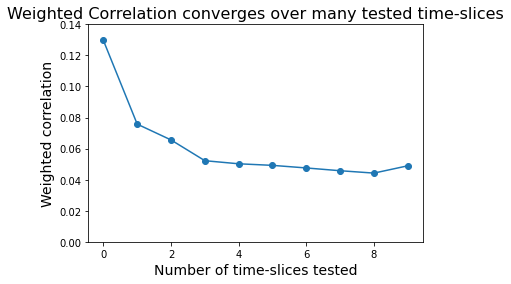

In [186]:
plt.plot(range(10), weighted_correlations, '-o')
plt.title("Weighted Correlation converges over many tested time-slices", fontsize = 16)
plt.xlabel("Number of time-slices tested",fontsize = 14)
plt.ylabel("Weighted correlation", fontsize = 14)
plt.ylim(0,0.14)
plt.show()

In the code block below, I check how well XGBoost performs over many epochs (num_estimators). I used these plots to check for any signs of overfitting while tuning my model hyperparameters.

In [183]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.ylim(0, 0.05)
plt.show()

Having completed a forecasting model with XGBoost, I could perform further feature selection, by finding which features were the least valuable for the fitted XGBoost and deleting them for further forecasting. The code block below shows how I can do this using TreeShap. However, having tried it, I found that the process, in practice, *reduced* the weighted correlation significantly. I therefore did not use this feature selection method in the final forecasting model.

In [73]:
# Treeshap can in 
# import shap
# shap_values = shap.TreeExplainer(model).shap_values(X_train)
# shap.summary_plot(shap_values, X_train, plot_type="bar", max_display = 98)